In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

Выводов получилось не очень много, но надо понимать, что объем данных весьма ограничен, если будет больше переменных, то можно будет произвести намного более детальный анализ

### Загрузка датасета и небольшое изучение

In [2]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/vk_task/video_sessions_transformed.csv")

In [3]:
display(data.head())

,user_id,video_owner_id,total_view_time,vk_platform,nav_screen,video_id
0,5137060586,197846393764,0,vk_video_ios,video_for_you,1524753638856
1,6791352918,255312742952,0,vk_video_android,video_search,1524750811524
2,8499858010,290290140528,2,vk_video_android,video_for_you,1524751697154
3,13064371614,296968444192,0,vk_video_android,video_search,1524751112304
4,15865765790,283074246524,0,vk_video_android,video_for_you,1524752278662


In [4]:
display(data.shape)
display(data.info())

(4503, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4503 entries, 0 to 4502
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user_id          4503 non-null   int64 
 1   video_owner_id   4503 non-null   int64 
 2   total_view_time  4503 non-null   int64 
 3   vk_platform      4503 non-null   object
 4   nav_screen       4503 non-null   object
 5   video_id         4503 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 211.2+ KB


None

In [5]:
display(data.isna().any())

,0
user_id,False
video_owner_id,False
total_view_time,False
vk_platform,False
nav_screen,False
video_id,False


In [6]:
display(data["nav_screen"].value_counts())

,count
nav_screen,
video_for_you,2213
video_search,2068
video_my_history,95
video_group_all,93
video_my_added,14
catalog_other,7
video_my_bookmarks,6
video_playlist,4
video_group_main,2


In [7]:
display(data["total_view_time"].value_counts())

,count
total_view_time,
0,2550
1,547
2,307
3,162
4,109
...,...
1741,1
1184,1
53,1


NaN-ов в данных нет, все колонки имеют значение, проверять на корреляцию смысла нет (только одна числовая колонки, остальные категориальные и id), строить какую-либо модель на этих данных тоже смысла нет (мало данных, регрессоров тоже).

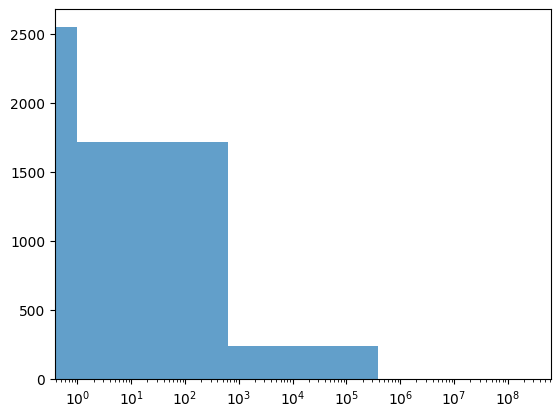

In [8]:
custom_bins = [0] + list(np.logspace(0, np.log10(data["total_view_time"][data["total_view_time"] > 0].max()), 4))

plt.hist(data["total_view_time"], bins=custom_bins, alpha=0.7, label="Исходные данные")
plt.xscale("log")
plt.show()

Можно заметить, что в колонке "total_view_time" много нулей и небольших значений (пользователь открыл видеоролик и сразу закрыл его, случайный просмотр)

Надо удалить эти малоинформативные просмотры (воспользуемся понятием осознанного просмотра, который длится больше 30 секунд). Возможно использование более низкого порога осознанного просмотра (например, в случае клипов это может быть 10 секунд).

### 1

In [9]:
data_1 = data[data["total_view_time"] > int(30)]

In [10]:
display(data_1["total_view_time"].value_counts())

,count
total_view_time,
1200,3
47,3
100,3
35,3
33,3
...,...
3362,1
2335,1
2908,1


In [11]:
display(data_1.shape)

(397, 6)

In [12]:
bins = np.logspace(np.log10(data_1["total_view_time"].min()),
                   np.log10(data_1["total_view_time"].max()),
                   20)

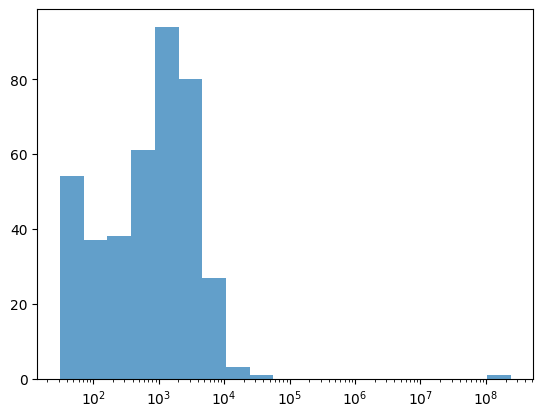

In [13]:
plt.hist(data_1["total_view_time"], bins=bins, alpha=0.7, label="Исходные данные")
plt.xscale("log")
plt.show()

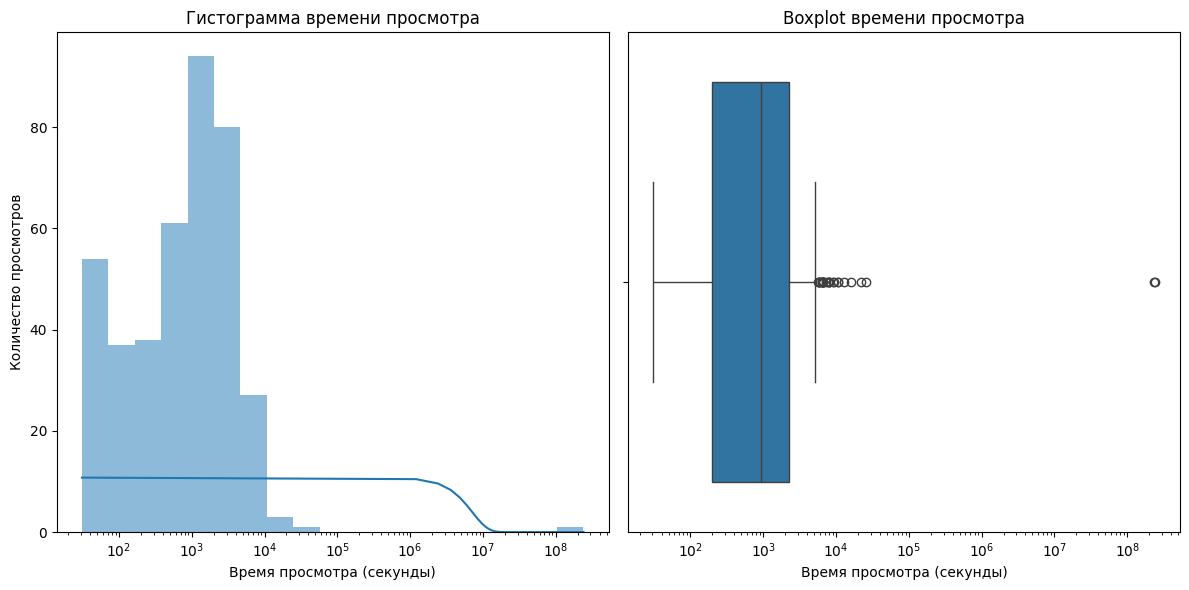

In [14]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=data_1, x="total_view_time", bins=bins, kde=True)
plt.title("Гистограмма времени просмотра")
plt.xlabel("Время просмотра (секунды)")
plt.ylabel("Количество просмотров")
plt.xscale("log")
# plt.xlim(30, 1000)

plt.subplot(1, 2, 2)
sns.boxplot(data=data_1, x="total_view_time")
plt.title("Boxplot времени просмотра")
plt.xlabel("Время просмотра (секунды)")
plt.xscale("log")
plt.tight_layout()
# plt.xlim(5, 1000)
plt.show()

Очищать можно с помощью межквантильного размаха (IQR) или с помощью стандартного отклонения. Я воспользуюсь методом 3 сигм как более щадящим в нашем случае, ниже есть бокс плот,  который покажет изменение данных в зависимсти от отчистки

In [15]:
def out_of_bounds(data, how="sigma"):
  if how == "iqr":
    Q1 = data["total_view_time"].quantile(0.25)
    Q3 = data["total_view_time"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
  elif how == "sigma":
    mean = data["total_view_time"].mean()
    std = data["total_view_time"].std()
    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std
  data_clean = data[(data["total_view_time"] >= lower_bound) & (data["total_view_time"] <= upper_bound)]
  print(f"Исходные данные: {len(data)} записей")
  print(f"После очистки: {len(data_clean)} записей")
  print(f"Удалено {len(data) - len(data_clean)} выбросов ({((len(data)-len(data_clean))/len(data))*100:.2f}%)")
  return data_clean

data_clean = out_of_bounds(data_1, "sigma")

Исходные данные: 397 записей
После очистки: 395 записей
Удалено 2 выбросов (0.50%)


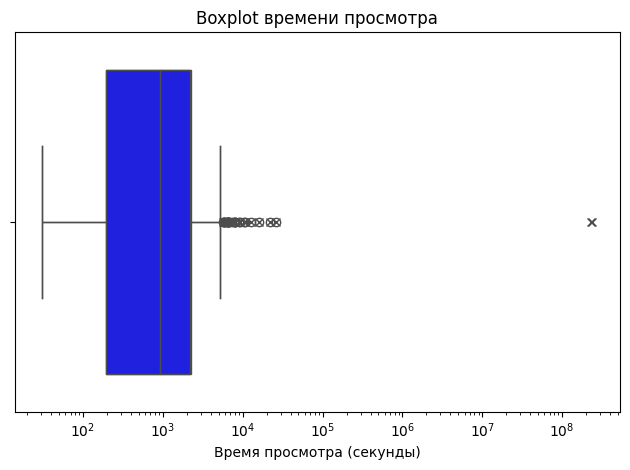

In [16]:
sns.boxplot(data=data_1, x="total_view_time", color="r", flierprops={"marker": "x"})
sns.boxplot(data=data_clean, x="total_view_time", color="b")
plt.title("Boxplot времени просмотра")
plt.xlabel("Время просмотра (секунды)")
plt.xscale("log")
plt.tight_layout()
# plt.xlim(5, 1000)
plt.show()

### 2

Видно, что большее число просмотров после отчистки имеет андройд, как более популярная платформа

In [17]:
platform_counts = data_clean["vk_platform"].value_counts().reset_index()
platform_counts.columns = ["Platform", "Count"]
display(platform_counts)

,Platform,Count
0,vk_video_android,272
1,vk_video_ios,123


### 3

Просто строим самые популярные сообщества по времени просмотра

,video_owner_id,total_view_time
0,279672446984,104377
1,105949036644,38576
2,279942606536,34535
3,145819277544,30998
4,292769954132,24368
5,140097381168,23900
6,283348041780,22164
7,292278366172,20423
8,225987071076,16113
9,283074246524,13077


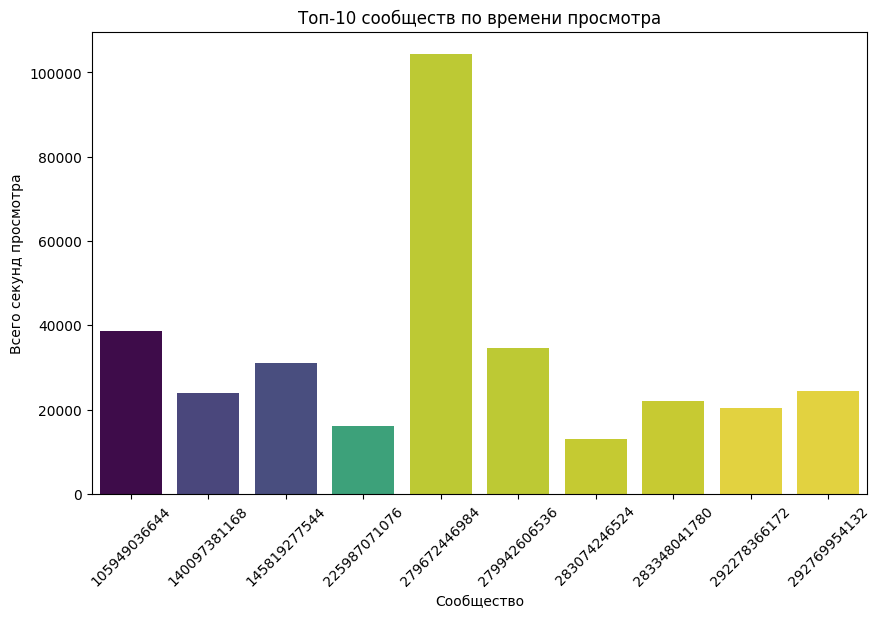

In [18]:
top_communities = data_clean.groupby("video_owner_id")["total_view_time"].sum().nlargest(10).reset_index()
top_communities = top_communities.sort_values(by="total_view_time", ascending=False)
display(top_communities)
plt.figure(figsize=(10, 6))
sns.barplot(x="video_owner_id", y="total_view_time", data=top_communities, palette="viridis", hue="video_owner_id", legend=False)
plt.title("Топ-10 сообществ по времени просмотра")
plt.xlabel("Сообщество")
plt.ylabel("Всего секунд просмотра")
plt.tick_params(axis='x', rotation=45)
plt.show();

### 4

Дополнительно можно построить пару графиков

In [19]:
data_views = (data_clean.groupby(["video_id"])["total_view_time"].mean()).nlargest(10).reset_index()
data_channels = (data_clean.groupby(["video_owner_id"])["total_view_time"].mean()).nlargest(10).reset_index()
display(data_views.head(10))
display(data_channels.head(10))

,video_id,total_view_time
0,1524763033218,25945.0
1,1524758705328,22164.0
2,1524756676734,16113.0
3,1524755520402,12811.0
4,1524791293170,10704.0
5,1524812949330,10526.0
6,1524752816724,9256.0
7,1524764714244,8944.0
8,1524775692714,7999.0
9,1524765800394,7963.0


,video_owner_id,total_view_time
0,283348041780,22164.0
1,225987071076,16113.0
2,270249683300,12811.0
3,-328314047540,10704.0
4,70647006184,7999.0
5,105410122304,7835.0
6,105949036644,7715.2
7,286522930228,7386.0
8,135952837488,6028.0
9,296176204960,5840.0


Заметим, что некоторые сообщества пересекаются с теми, которые уже были в топе по времени просмотра, видимо благодаря высокому времени удержания просмотра они там и оказались

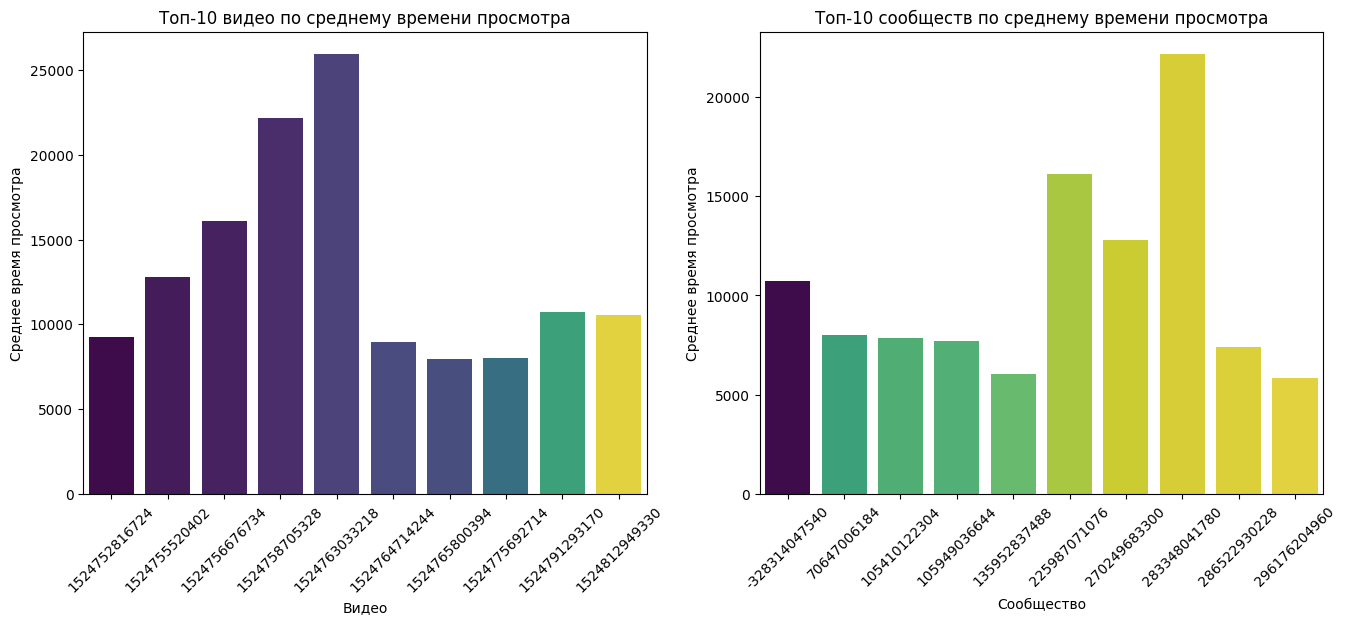

In [20]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.barplot(x="video_id", y="total_view_time", data=data_views, palette="viridis", hue="video_id", legend=False)
plt.title("Топ-10 видео по среднему времени просмотра")
plt.xlabel("Видео")
plt.ylabel("Среднее время просмотра")
plt.tick_params(axis='x', rotation=45)
plt.subplot(1, 2, 2)
sns.barplot(x="video_owner_id", y="total_view_time", data=data_channels, palette="viridis", hue="video_owner_id", legend=False)
plt.title("Топ-10 сообществ по среднему времени просмотра")
plt.xlabel("Сообщество")
plt.ylabel("Среднее время просмотра")
plt.tick_params(axis='x', rotation=45)
plt.show();

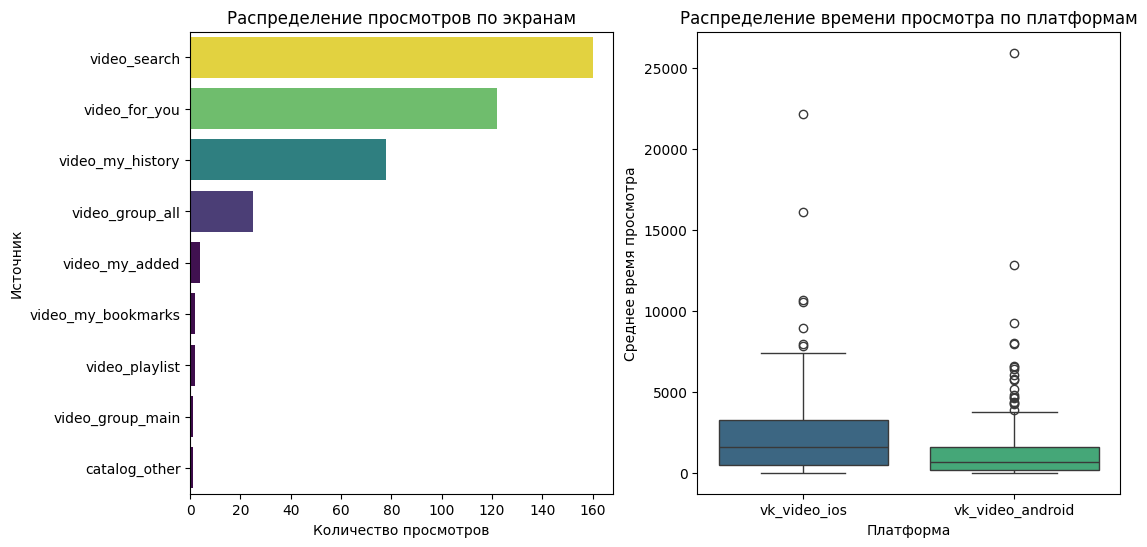

In [21]:
screen_distribution = data_clean["nav_screen"].value_counts().reset_index()
avg_time_platform = data_clean.groupby("vk_platform")["total_view_time"].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x="count", y="nav_screen", data=screen_distribution, palette="viridis", hue="count", legend=False)
plt.title("Распределение просмотров по экранам")
plt.ylabel("Источник")
plt.xlabel("Количество просмотров")
plt.subplot(1, 2, 2)
sns.boxplot(x="vk_platform", y="total_view_time", data=data_clean, palette="viridis", hue="vk_platform", legend=False)
plt.title("Распределение времени просмотра по платформам")
plt.xlabel("Платформа")
plt.ylabel("Среднее время просмотра")
plt.show()

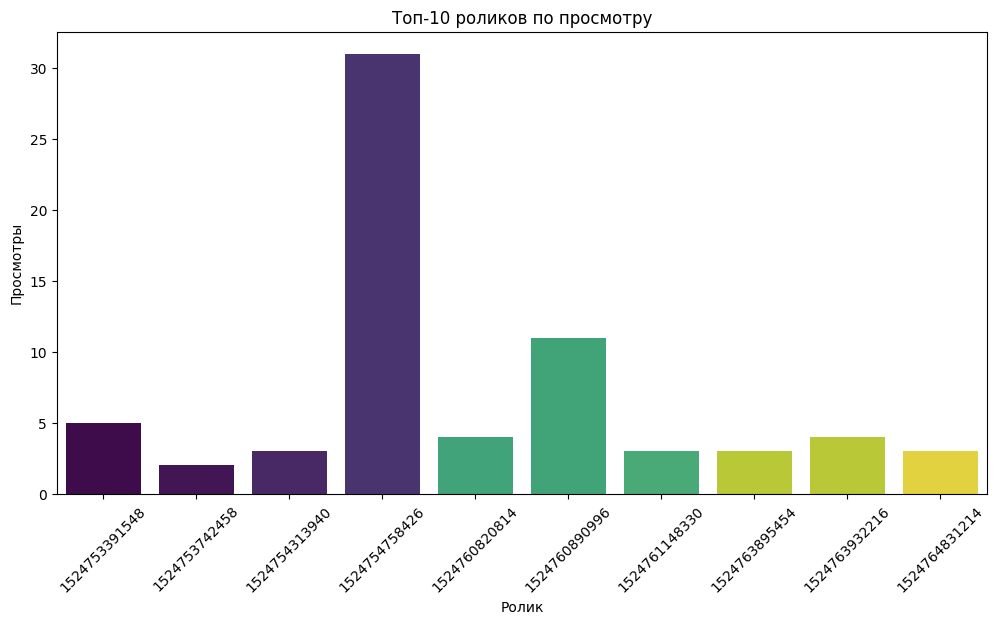

In [22]:
top_views = data_clean["video_id"].value_counts().nlargest(10).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x="video_id", y="count", data=top_views, palette="viridis", hue="video_id", legend=False)
plt.title("Топ-10 роликов по просмотру")
plt.xlabel("Ролик")
plt.ylabel("Просмотры")
plt.tick_params(axis='x', rotation=45)
plt.show()